### Preamble setup

In [1]:
import random
import numpy as np
import sys
np.set_printoptions(threshold=sys.maxsize) # display the complete matrix
import matplotlib.pyplot as plt
from __future__ import division 
from scipy import stats
import scipy
from tqdm import tqdm

In [2]:
## global variables and parameters
l = 20 #length of m1's chamber
m1 = 2
m2 = 1
m = m1+m2

## billiard representation
l2 = l*(m2/m)**(1/2) # when the position of the second billiard, represented by y, is in (0,l1), m2 is in the entry chamber, also the billiard (x,y) is in the triangle area
l1 = l*(m1/m)**(1/2)
theta = np.arctan((m2/m1)**(1/2)) # angle between the hypotenuse and the top side
print("l1, l2: ",l1,l2)

# normal distribution of v1
mu = 0 # velocity can be positive or negative, define the positive direction to be the right
sigma =5

# three points of the triangle
left_top = [0,l2]
bottom = [0,0]
right_top = [l1,l2]

#--------------------------------------------------------

def line(p1, p2): # input list, [0] is x, [1] is y
    A = (p1[1] - p2[1]) # delta y
    B = (p2[0] - p1[0]) # delta x
    C = (p1[0]*p2[1] - p2[0]*p1[1])
    return A, B, -C

'''
Input: two lines, both are 3-element tuples
Return: one 2-element tuple or False
'''
def intersection(L1, L2): # input two lines
    D  = L1[0] * L2[1] - L1[1] * L2[0]
    Dx = L1[2] * L2[1] - L1[1] * L2[2]
    Dy = L1[0] * L2[2] - L1[2] * L2[0]
    # print(D)
    if D != 0:
        x = Dx / D
        y = Dy / D
        # print('case 1')
        return x,y
    else:
        # print('case 2')
        return False
    

def angle(vector_1, vector_2): # input two vectors [x,y]
    unit_vector_1 = vector_1 / np. linalg. norm(vector_1)
    unit_vector_2 = vector_2 / np. linalg. norm(vector_2)
    dot_product = np. dot(unit_vector_1, unit_vector_2)
    angle = np. arccos(dot_product)
    return angle # in radians

l1, l2:  16.32993161855452 11.547005383792515


In [3]:
left = line(left_top, bottom)
top = line(left_top, right_top)
hypo = line(bottom, right_top)
'''
determine where the next collision will be.
input: current x,y,v1,v2
return: v2
'''
def collide(x,y,v1,v2):
    x_list = []
    y_list = []
    while True:
        x_list.append(x)
        # x_alt.append(x)
        y_list.append(y)
        # y_alt.append(y)
        p1 = [x,y]
        p2 = [x+v1,y+v2]
        # x_alt.append(p2[0])
        # y_alt.append(p2[1])
        way = line(p1,p2) # the intended straight-line motion

        # which side will the velocity vector intersect, within the range of the triangle
        xLeft = intersection(way, left)
        alreadyHit = False
        if xLeft:
            if xLeft[0]==0 and xLeft[1]<l2 and xLeft[1]>0 and v1<0: 
                alreadyHit = True
                x = xLeft[0]
                y = xLeft[1]
                v1,v2 = hitLeft(v1,v2) # velocity after collision
                # print("v1,v2 after colliding with left is ", v1,v2)                    

        xTop = intersection(way, top)
        # print("xTop: ",xTop)
        if xTop:
            if xTop[0]<l1 and xTop[0]>0 and v2>0:
                alreadyHit = True
                x_list.append(xTop[0])
                y_list.append(xTop[1])
                # out, record the exiting v2
                # v2_seq.append(v2)
                # print("out:",v2)
                break
                
        xHypo = intersection(way, hypo)
        if xHypo: # incase the vector is parallel to hypo and xhypo is a boolean
            if xHypo[0]<l1 and xHypo[0]>0 and xHypo[1]<l2 and xHypo[1]>0 and alreadyHit == False: # assumption: the line only intersects with one of the three sides within the range
                x = xHypo[0]
                y = xHypo[1]
                v1,v2 = hitHypo(v1,v2) # velocity after collision
                # print("v1,v2 after colliding with hypotenuse is ",v1, v2)

    # after exiting the while loop            
    return v2

'''
Given the collision position and a velocity vector, find the reflected velocity.
Input: v1, v2
Output: v1, v2
'''
def hitHypo(v1,v2):
    # find new velocity
    V = (v1**2+v2**2)**(1/2) # norm of velocity
    upHyp = [l1,l2] # vector in the up direction along the hypotenuse
    vector_v = [v1,v2]
    intersection_angle = angle(vector_v,upHyp)
    beta = np.pi - intersection_angle - theta
    v1 = -np.cos(beta)*V
    v2 = np.sin(beta)*V
    return v1,v2
    
def hitLeft(v1,v2):
    # find new velocity
    v1 = -v1
    return v1,v2

### Simulation of Collision with Two Walls

In [4]:
'''
Initialize m1 by choosing its position and velocity from uniform distribution and normal distribution respectively.
Returns the position and velocity of m1.
'''
# sigma_1,sigma_2 = 30,15
def activateM1(): # left wall
    x = random.uniform(0,l1) # generate a position within the range (0,l1)
    # print("sigma_1:",sigma_1)
    v1 = random.gauss(0, sigma_1) # set mu=0
    return x,v1

def activateM3(): # right wall
    x3 = random.uniform(0,l1) # generate a position within the range (0,l1)
    v3 = random.gauss(0, sigma_2) # mu, sigma
    return x3,v3

In [5]:
# two temperature system
# assume M1 is attached to the left wall, M3 to the right wall
def sim_P1(initial_v2,n): # collide with M3 at the left wall
    v2 = initial_v2
    vl_seq = [] # speeds after colliding with the left wall
    for i in range(n):
        # collide with the left wall
        x,v1 = activateM1()
        temp = collide(x,l2,v1,v2) 
        # v2 = -temp # make sure any input v2 is negative # comment out this line for generating matrix P, we always input the same v2 to get a row in P
        vl_seq.append(temp) 

        # # collide with m3 at the right wall (m3 has the same mass as m1)
        # x3,v3 = activateM3()
        # temp = collide(x3,l2,v3,v2) # in the reverse direction
        # vr_seq.append(temp)
        # # v2 = -temp # comment out this line for generating matrix P, we always input the same v2 to get a row in P
    
    return vl_seq


def sim_P2(initial_v2,n): # last collision is with M1
    v2 = initial_v2
    vr_seq = []
    for i in range(n):
        # collide with m3 (m3 has the same mass as m1)
        x3,v3 = activateM3()
        temp = collide(x3,l2,v3,v2) # in the reverse direction
        # v2 = -temp 
        vr_seq.append(temp) # only append the final speed

        # # make sure the last collision was with M1
        # x,v1 = activateM1()
        # temp = collide(x,l2,v1,v2)
        # # v2 = -temp # make sure any input v2 is negative
        
    return vr_seq

In [ ]:
# # distribution for sim_P1 with fixed initial v2
# results = sim_P1(-1,10000) # v2 should always be negative
# print("average: ",np.average(results))
# plt.hist(results, 120)

In [ ]:
# # distribution for sim_P2 with fixed initial v2
# results_P2 = sim_P2(-1,10000) # v2 should always be negative
# print("average: ",np.average(results_P2))
# plt.hist(results, 120)

### Finding P1 (speeds after colliding with left wall) and P2 (right wall)

In [6]:
def getP1(n):
    # transition matrix
    P = np.zeros((n,n))
    results = []
    for i in range(0,n): # index of the row, meaning the initial speed # speed starts from 1
        rep = 1000
        initial_v2 = -i # v2 should always be negative
        if i == 0:
            initial_v2 = -0.0000000001
        results = sim_P1(initial_v2, rep)  # results is the list of speeds after one collision
        # print("len(results)",len(results)) # length of results should be exactly equal to rep every time
        int_results = [round(x) for x in results] # same number as rep

        # fill up the i-th row
        if len(int_results)==rep:
            for j in range(0,n):
                # if j is not the last element n-1
                if j != n-1:
                    occur = int_results.count(j)
                    p = occur/rep
                    P[i][j] = p
                if j == n-1:
                    P[i][j]=1-np.sum(P[i][0:j]) # P[i][0:j] is the sum of the i-th row except for the last element
            # print("sum of P[{}] is ".format(i), np.sum(P[i]))
        else:
            print("len(int_results)!=rep",len(results))
    return P

def getP2(n):
    # transition matrix
    P = np.zeros((n,n))
    for i in range(0,n): # index of the row, meaning the initial speed # speed starts from 1
        rep = 5000
        initial_v2 = -i # v2 should always be negative
        if i == 0:
            initial_v2 = -0.0000000001
        results = sim_P2(initial_v2, rep)  # results is the list of speeds after one collision
        # print("len(results)",len(results)) # length of results should be exactly equal to rep every time
        int_results = [round(x) for x in results] # same number as rep

        if len(int_results)==rep:
            # fill up the i-th row
            for j in range(0,n):
                # if j is not the last element n-1
                if j != n-1:
                    occur = int_results.count(j)
                    p = occur/rep
                    P[i][j] = p
                if j == n-1:
                    P[i][j]=1-np.sum(P[i][0:j]) # P[i][0:j] is the sum of the i-th row except for the last element
        
        else:
            print("len(int_results)!=rep",len(results))
        # print("sum of P[{}] is ".format(i), np.sum(P[i]))

    # print("P:",P)
    return P
    

In [7]:
# matrix size
n = 120 # range of initial and transitioned speeds
sigma_1 = 10
sigma_2 = 15
P1 = getP1(n)
# print(P1[99])

In [8]:
# matrix size
n = 120 # range of initial and transitioned speeds
P2 = 0
sigma_2 = 15
P2 = getP2(n)
# print(P2[99])

###Finding the Limiting Distribution: the eigenvector corresponding to the largest eigenvalue

In [ ]:
def find_eig(P):
    values, vectors = scipy.sparse.linalg.eigs(P, k=1)
    real_vec = np.real(vectors)
    real_val = np.real(values)
    
    norm = sum(real_vec.flatten())
    normal_vec = real_vec.flatten()/norm

    return normal_vec 

[ 1.24429788e-03  1.02268095e-02  1.90796708e-02  3.06638213e-02
  3.53325580e-02  4.38780264e-02  4.93193042e-02  5.78291611e-02
  5.76625682e-02  5.84142289e-02  5.76259117e-02  5.89187062e-02
  6.02813548e-02  5.58916050e-02  5.47247211e-02  4.88782893e-02
  4.46919165e-02  3.98313792e-02  3.45884791e-02  3.17728434e-02
  2.73247965e-02  2.16809857e-02  1.93126532e-02  1.66766526e-02
  1.25975559e-02  1.14651655e-02  8.69658869e-03  7.82863989e-03
  5.49326754e-03  4.26656347e-03  3.54461215e-03  2.45795204e-03
  2.49822738e-03  1.60326117e-03  1.16804123e-03  7.06207529e-04
  5.49290447e-04  3.55176558e-04  2.87614977e-04  1.66903293e-04
  1.15535163e-04  1.26345848e-04  1.26009474e-04  5.90608968e-05
  1.39275771e-05  7.99050144e-06  7.27816754e-06  3.71319017e-06
  7.30780960e-07  6.27690681e-07  8.07236140e-07  1.95767117e-06
  1.07132492e-07  2.26737137e-08  2.00874679e-08  1.22732651e-08
  2.59246979e-08  8.33290307e-09  8.41522738e-09  2.39288363e-09
  1.00099164e-10  8.12063

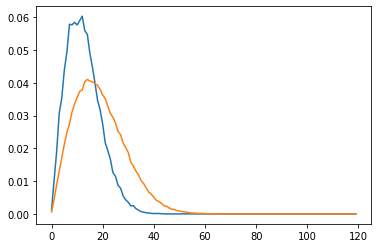

In [ ]:
pi1 = find_eig(P1.transpose()) # after collision with the left wall
pi2 = find_eig(P2.transpose()) # after collision with the right wall
plt.plot(pi1)
plt.plot(pi2)
print(pi1)

### Entropy Production Rate

1. find change of kinetic energy at each wall

    a. 2 list of speeds, before and after the collision
2. explore how the entropy production rate depends on the temperature difference

In [ ]:
def ep(pi1,pi2):
    expected_vl_sq = np.arange(pi1.shape[0])**2@pi1
    # print(expected_vl_sq) # normalized, expected v (leaving left wall) squared

    expected_vr_sq = np.arange(pi2.shape[0])**2@pi2
    # print(expected_vr_sq) # normalized, expected v (leaving right wall) squared

    # change of kinetic energy at left wall: 
    KE_left = m2*(expected_vr_sq-expected_vl_sq)/2
    KE_right = -KE_left
    ep = KE_left/sigma_1+KE_right/sigma_2 # entropy production rate
    return ep

In [ ]:
ep(pi1,pi2)

4.152248204138864

Assuming $\sigma = \sqrt{\frac{kT}{m}}$.

In [ ]:
ratio = np.linspace(0.001,0.04,5)
ratio

array([0.001  , 0.01075, 0.0205 , 0.03025, 0.04   ])

mass ratio is:  0.001
15
delta temperature is  0
ep is  0.0
17.5
delta temperature is  81.25
ep is  0.0010001356336977445
20
delta temperature is  175
ep is  0.0017970073486858846
22.5
delta temperature is  281.25
ep is  0.0037025982296291626
30
delta temperature is  675
ep is  0.020402746398852718
35
delta temperature is  1000
ep is  0.037777641091694424
mass ratio is:  0.0205
15
delta temperature is  0
ep is  0.0
17.5
delta temperature is  81.25
ep is  0.015899864891330814
20
delta temperature is  175
ep is  0.06038646940601042
22.5
delta temperature is  281.25
ep is  0.1317302230103457
30
delta temperature is  675
ep is  0.4322038012194486
35
delta temperature is  1000
ep is  0.7475034906605692
mass ratio is:  0.04
15
delta temperature is  0


KeyboardInterrupt: ignored

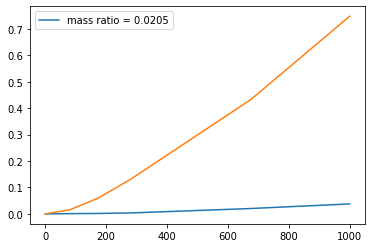

In [ ]:
ratio = np.linspace(0.001,0.04,3)
gaps = []
delta_temp_and_ep = []
for r in ratio:
    print("mass ratio is: ", r)
    ## set the mass ratio and relevant terms
    ## global variables and parameters
    m1 = 1
    m2 = r
    l = 20 
    m = m1+m2

    ## billiard representation
    l2 = l*(m2/m)**(1/2) # when the position of the second billiard, represented by y, is in (0,l1), m2 is in the entry chamber, also the billiard (x,y) is in the triangle area
    l1 = l*(m1/m)**(1/2)
    theta = np.arctan((m2/m1)**(1/2)) # angle between the hypotenuse and the top side

    # normal distribution of v1
    mu = 0 # velocity can be positive or negative, define the positive direction to be the right
    sigma = 30

    # three points of the triangle
    left_top = [0,l2]
    bottom = [0,0]
    right_top = [l1,l2]

    # define the following for the function collide
    left = line(left_top, bottom)
    top = line(left_top, right_top)
    hypo = line(bottom, right_top)

    ## find the linear relationship between delta temperature and entropy
    sig1_list = [15,17.5,20,22.5,30,35]
    ep_list = []
    delta_temp_list = []
    m_left = 1
    m_right = 1

    sigma_2 = 15
    P2 = getP2(120)
    pi2 = find_eig(P2.transpose()) # after collision with the right wall

    for i in range(len(sig1_list)):
        sigma_1 = sig1_list[i]
        print(sigma_1)
        delta_temp_i = sigma_1**2*m_left - sigma_2**2*m_right
        print("delta temperature is ", delta_temp_i)
        delta_temp_list.append(delta_temp_i)

        # get a list of ep and explore its linear dependence on temperature difference
        P1 = getP1(120)
        pi1 = find_eig(P1.transpose()) # after collision with the left wall
        ep_i = ep(pi1,pi2)
        ep_list.append(ep_i)
        print("ep is ",ep_i)

    temp_list = [delta_temp_list,ep_list]
    delta_temp_and_ep.append(temp_list)
    plt.plot(delta_temp_list,ep_list)
    plt.legend(["mass ratio = {}".format(r)])

### To Do: Make a plot with only positive x-axis

### Matrix multiplication, high powers of P

In [ ]:
def matrixMul(matrix, n):
    if(n == 1):
        return matrix
    else:
            tempArr = matrix;
            for i in range(1, n-1):
                tempArr = np.matmul(matrix, tempArr)
            return tempArr

In [ ]:
# look at some row of the matrix P^n
def Pn_i(n, Pn, i): 
    if i <= len(Pn)-1:
        print("When n = {}".format(n))
        print("Sum of the {}-th row: ".format(i), sum(Pn[i])) # after taking the powers of P, the sum of the probabilities is smaller
        # print("Distribution of the {}-th row: ".format(i), Pn[i])
        plt.plot(Pn[i])
        plt.title("Distribution of the {}-th row: ".format(i))

In [ ]:
n = 100
Pn = matrixMul(P, n) # find limiting distribution P^n
print(Pn_i(n, Pn, 9))
n = 1000
Pn = matrixMul(P, n) # find limiting distribution P^n
print(Pn_i(n, Pn, 9))

see the case where m1 > m2

think about higher initial speed rows - google.